In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.matrices import Matrices, MatricesMetric

/Users/junhaozhu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/junhaozhu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO: Using numpy backend


In [2]:
import pandas as pd

In [3]:

# define the manifold to be d*d spd matrix, d = 2 
d=6
from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(dim=d) 
mfd= sphere.metric


In [4]:
import numpy.fft as fft
import scipy.stats as stats

In [5]:
from tqdm import tqdm_notebook as tqdm

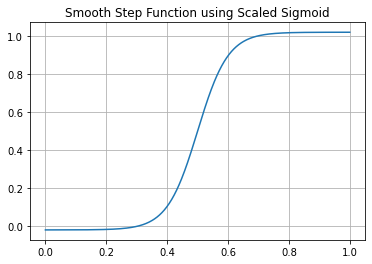

In [43]:
# def smooth_step(x, a=0.3, b=0.7, k=20):
#     c = (a + b) / 2
#     fx = 1 / (1 + np.exp(-k * (x - c)))
#     # Normalize
#     fa = 1 / (1 + np.exp(-k * (a - c)))
#     fb = 1 / (1 + np.exp(-k * (b - c)))
#     return (fx - fa) / (fb - fa)

# x = np.linspace(0, 1, 500)
# y = smooth_step(x)

# plt.plot(x, y)
# plt.title("Smooth Step Function using Scaled Sigmoid")
# plt.grid(True)
# plt.show()

In [44]:
smooth_step(0)

-0.018610268486279356

In [6]:
bp0 = np.array([0,0,0,0,0,0,1])

def smooth_step(x, a=0.3, b=0.7):
    x = gs.clip(x, 0, 1)
    t = (x - a) / (b - a)
    phi = lambda t: np.exp(-1 / (t * (1 - t))) * (t > 0) * (t < 1)
    numerator = phi(t)
    denominator = numerator + phi(1 - t)
    result = gs.where(x <= a, 0, np.where(x >= b, 1, numerator / denominator))
    return result



def sigmoid(x, c=0.5, k=20):
   # x = gs.clip(x, 0, 1)
    fx = 1 / (1 + np.exp(-k * (x - c)))
    #t = (x - a) / (b - a)
   # phi = lambda t: np.exp(-1 / (t * (1 - t))) * (t > 0) * (t < 1)
   # numerator = phi(t)
    #denominator = numerator + phi(1 - t)
    #result = gs.where(x <= a, 0, np.where(x >= b, 1, numerator / denominator))
    return fx
def generate_sample_tangent_space(base=bp0,n_samples=1,sigma=1): 
    # generate i.i.d gaussian noise on tangent space 
    size = (n_samples, d) if n_samples != 1 else (1,d)
    X =  np.zeros((n_samples,d))
    tangent_vec =  np.zeros((n_samples,d+1))
    for i in range(n_samples):
        # Generate uniform random variables a_i on [-0.5, 0.5]
        a_i_1 = gs.random.uniform(-0.5, 0.5)
        a_i_2 = gs.random.uniform(-0.5, 0.5)
        # Generate Rademacher variables b_i (values -1 or 1 with equal probability)
        b_i_1 = gs.random.choice([-1, 1])/gs.sqrt(12)
        b_i_2 = gs.random.choice([-1, 1])/gs.sqrt(12)
        
        a_i_3 = gs.random.uniform(-0.5, 0.5)
        b_i_3 = gs.random.uniform(-0.5, 0.5)
        #wi = smooth_step(i/T, a=0.3, b=0.7)
        wi =sigmoid(i/n_samples, c=0.5, k=200)
        # Calculate the time series for this row
        X[i, 3] =0.5*sigma*((wi)**0.5 * a_i_1 + (1 - wi)**0.5 * b_i_1)
        X[i, 4] =1.5*sigma*((wi)**0.5 * a_i_2 + (1 - wi)**0.5 * b_i_2)
        X[i, 5] =3*sigma*((wi)**0.5 * a_i_3 + (1 - wi)**0.5 * b_i_3)
    #sqrt_base_point = gs.linalg.sqrtm(base_point)
    tangent_vec[:,:d]=X
    return tangent_vec 

# def generate_sample_tangent_space_rademacher(base=bp0,n_samples=1,sigma=1): 
#     # generate i.i.d gaussian noise on tangent space 
#     size = (n_samples, d) if n_samples != 1 else (1,d)
    
#     tangent_vec_aux = sigma*(gs.random.choice([-1,1],size=size))
#     tangent_vec = np.zeros(shape=(n_samples, d+1))
#     tangent_vec[:,:d]=tangent_vec_aux
#     #sqrt_base_point = gs.linalg.sqrtm(base_point)
#     return tangent_vec


def generate_random_sample(base=bp0,n_samples=1,sigma=1):
    # generate sample with Frechet mean equal the given base point.
    tv =  generate_sample_tangent_space(base=base,n_samples=n_samples,sigma=sigma)
    return mfd.exp(tangent_vec=tv,base_point=base)



In [8]:
#find or basis of T_p
def Proj(x):
    d = x.shape[0]
    y = np.reshape(x,(d,1))
    return(np.eye(d)-np.dot(y,y.T))

def OR(x):
    #return or basis for T_x S
    P = Proj(x)
    l,u= np.linalg.eig(P)
    idx = l>0.001
    #np.linalg.eig(P)
    return u[:,idx]

def coord(residual,x):
    E = OR(x)
    Y = np.dot(residual,E)
    return(Y)

def mft(Y):
    d = Y.shape[1]
    n = Y.shape[0]
    l = n//2+1
    D  = fft.fft(Y,axis=0)[0:l]/np.sqrt(2*np.pi*n)
  
    return D
    

In [92]:
# tau_lst = [0]
# #T_lst = [256,512,1024]
# T_lst = [256,512,1024]
# for a in range(len(tau_lst)):
#     for b in range(len(T_lst)):
#         tau = tau_lst[a]
#         T =T_lst[b]# sample size
#         m =  8

#         n = T // m  # 64
#         repli_s =5000
#         L = n//2+1
#         u = (n * np.arange(m) + n / 2) / T
#         omega = 2 * np.pi * np.arange(1, n + 1) / n
#         d = 6
#         sigma=1.3
#        # rho=0.1
#         z = np.zeros(repli_s)
#         z2 = np.zeros(repli_s)
#         for kk in tqdm(range(repli_s)):
#             np.random.seed(kk)
#             bp0 = np.array([0,0,0,0,0,0,1])
#             data =  generate_random_sample(base=bp0,n_samples=T,sigma=sigma)
#             fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
#             fmean.fit(data)
#             mean1 =fmean.estimate_
            
#            # mean1 = np.array([0,0,0,0,0,np.sqrt(48/49),1/7])
#             residual1=  mfd.log(point=data,base_point=mean1)
#             #residual2=  mfd.log(point=data,base_point=mean2)
#             xx =coord(residual1,mean1)
            
#             #xx = ar(rho=0.01, T=T, d=6) for  test in Euclidean 

#             x = xx - np.mean(xx, axis=0)
           
#             D_my = np.zeros((m,L,6),dtype=complex)
          
#             for i in range(m):
#                 low = i*n
#                 up = (i+1)*n

#                 D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)
               
#             D_my_conj = np.conj(D_my)
#             D_mynorm = np.mean(np.abs(D_my)**2,axis=2)
        
#             #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
#             inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)
        
#             F1hat =  np.sum(np.square(np.abs(inner_products)))/T
        
#             V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
#             V_conj_transpose = np.conj(V)  # This is the complex conjugate 
        
#             V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
#             V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :] 
        
#                       # Now compute the outer product
#             Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

#             Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
#             Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

#             F2hat= Il_sq.mean()/2
#             Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
#             mhat = (F1hat-F2hat+Bhat/m)
#             #mhat = F1_hat-F2_hat
#             vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/(n-1))
#             z[kk] = np.sqrt(T)*mhat/vhat

#                         #fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
#             #fmean.fit(data)
#             #mean1 =fmean.estimate_
            
#             mean2 = np.array([0,0,0,gs.sqrt(12/64),2/8,7/8,1/8])
#             residual2=  mfd.log(point=data,base_point=mean2)
#             #residual2=  mfd.log(point=data,base_point=mean2)
#             xx2 =coord(residual2,mean2)
            
#             #xx = ar(rho=0.01, T=T, d=6) for  test in Euclidean 

#             x = xx2 - np.mean(xx2, axis=0)
           
#             D_my = np.zeros((m,L,6),dtype=complex)
          
#             for i in range(m):
#                 low = i*n
#                 up = (i+1)*n

#                 D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)
               
#             D_my_conj = np.conj(D_my)
#             D_mynorm = np.mean(np.abs(D_my)**2,axis=2)
        
#             #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
#             inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)
        
#             F1hat =  np.sum(np.square(np.abs(inner_products)))/T
        
#             V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
#             V_conj_transpose = np.conj(V)  # This is the complex conjugate 
        
#             V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
#             V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :] 
        
#                       # Now compute the outer product
#             Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

#             Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
#             Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

#             F2hat= Il_sq.mean()/2
#             Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
#             mhat = (F1hat-F2hat+Bhat/m)
#             #mhat = F1_hat-F2_hat
#             vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/(n-1))
#             z2[kk] = np.sqrt(T)*mhat/vhat


#             #vhat2 =np.sqrt(np.sum(np.mean(np.abs(inner_products2)**2,axis=0)**2)/(n-1))
            

#         #np.save('zval_muhat_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_t1rate.npy',z)
#         #np.save('zval_pre_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_t1rate.npy',z2)
#         print(np.mean(z>stats.norm.ppf(0.95)),np.mean(z2>stats.norm.ppf(0.95)))


In [10]:
bp0 = np.array([0,0,0,0,0,0,1])
c1=1
c2=1
c3=2
def generate_sample_tangent_space(base=bp0,n_samples=1,sigma=1,c1=0.5,c2=1,c3=2.5): 
    # generate i.i.d gaussian noise on tangent space 
    size = (n_samples, d) if n_samples != 1 else (1,d)
    X =  np.zeros((n_samples,d))
    tangent_vec =  np.zeros((n_samples,d+1))
    for i in range(n_samples):
        # Generate uniform random variables a_i on [-0.5, 0.5]
        a_i_1 = gs.random.uniform(-0.5, 0.5)
        a_i_2 = gs.random.uniform(-0.5, 0.5)
        a_i_3 = gs.random.uniform(-0.5, 0.5)
        # Generate Rademacher variables b_i (values -1 or 1 with equal probability)
        b_i_1 = gs.random.choice([-1, 1])/gs.sqrt(12)
        b_i_2 = gs.random.choice([-1, 1])/gs.sqrt(12)
        b_i_3 = gs.random.choice([-1, 1])/gs.sqrt(12)
      
        
        #wi = smooth_step(i/T, a=0.3, b=0.7)
        wi =sigmoid(i/n_samples, c=0.5, k=1024)
        # Calculate the time series for this row
#         X[i, 3] =0.5*sigma*((wi)**0.5 * a_i_1 + (1 - wi)**0.5 * b_i_1)
#         X[i, 4] =1*sigma*((wi)**0.5 * a_i_2 + (1 - wi)**0.5 * b_i_2)
#         X[i, 5] =3*sigma*((wi)**0.5 * a_i_3 + (1 - wi)**0.5 * b_i_3)
        
        X[i, 3] =c1*sigma*((wi)**0.5 * a_i_1 + (1 - wi)**0.5 * b_i_1)
        X[i, 4] =c2*sigma*((wi)**0.5 * a_i_2 + (1 - wi)**0.5 * b_i_2)
        X[i, 5] =c3*sigma*((wi)**0.5 * a_i_3 + (1 - wi)**0.5 * b_i_3)
    #sqrt_base_point = gs.linalg.sqrtm(base_point)
    tangent_vec[:,:d]=X
    return tangent_vec 

# def generate_sample_tangent_space_rademacher(base=bp0,n_samples=1,sigma=1): 
#     # generate i.i.d gaussian noise on tangent space 
#     size = (n_samples, d) if n_samples != 1 else (1,d)
    
#     tangent_vec_aux = sigma*(gs.random.choice([-1,1],size=size))
#     tangent_vec = np.zeros(shape=(n_samples, d+1))
#     tangent_vec[:,:d]=tangent_vec_aux
#     #sqrt_base_point = gs.linalg.sqrtm(base_point)
#     return tangent_vec


def generate_random_sample(base=bp0,n_samples=1,sigma=1):
    # generate sample with Frechet mean equal the given base point.
    tv =  generate_sample_tangent_space(base=base,n_samples=n_samples,sigma=sigma)
    return mfd.exp(tangent_vec=tv,base_point=base)

T_lst = [256,512,1024]

for b in range(len(T_lst)):
    T =T_lst[b]# sample size
    m =  8

    n = T // m  # 64
    repli_s =5000
    L = n//2+1
    u = (n * np.arange(m) + n / 2) / T
    omega = 2 * np.pi * np.arange(1, n + 1) / n
    d = 6
    sigma=1.4
    # rho=0.1
    z = np.zeros(repli_s)
    z2 = np.zeros(repli_s)
    for kk in tqdm(range(repli_s)):
    #kk=0
        gs.random.seed(kk)
        bp0 = np.array([0,0,0,0,0,0,1])
        data =  generate_random_sample(base=bp0,n_samples=T,sigma=sigma)
        fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
        fmean.fit(data)
        #mean1 =bp0
        mean1 =fmean.estimate_
        # mean1 = np.array([0,0,0,0,0,np.sqrt(48/49),1/7])
        residual1=  mfd.log(point=data,base_point=mean1)
        #residual2=  mfd.log(point=data,base_point=mean2)
        xx =coord(residual1,mean1)

        #xx = ar(rho=0.01, T=T, d=6) for  test in Euclidean 

        x = xx - np.mean(xx, axis=0)

        D_my = np.zeros((m,L,6),dtype=complex)

        for i in range(m):
            low = i*n
            up = (i+1)*n

            D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)

        D_my_conj = np.conj(D_my)
        D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

        #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
        inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)

        F1hat =  np.sum(np.square(np.abs(inner_products)))/T

        V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
        V_conj_transpose = np.conj(V)  # This is the complex conjugate 

        V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
        V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :] 

                  # Now compute the outer product
        Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

        Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
        Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

        F2hat= Il_sq.mean()/2
        Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
        mhat = (F1hat-F2hat+Bhat/m)
        #mhat = F1_hat-F2_hat
        vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/(n-1))
        z[kk] = np.sqrt(T)*mhat/vhat

                    #fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
        #fmean.fit(data)
        #mean1 =fmean.estimate_

        mean2 = np.array([0,0,0,gs.sqrt(10/64),2/8,7/8,1/8])
        residual2=  mfd.log(point=data,base_point=mean2)
        #residual2=  mfd.log(point=data,base_point=mean2)
        xx2 =coord(residual2,mean2)

        #xx = ar(rho=0.01, T=T, d=6) for  test in Euclidean 

        x = xx2 - np.mean(xx2, axis=0)

        D_my = np.zeros((m,L,6),dtype=complex)

        for i in range(m):
            low = i*n
            up = (i+1)*n

            D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)

        D_my_conj = np.conj(D_my)
        D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

        #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
        inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)

        F1hat =  np.sum(np.square(np.abs(inner_products)))/T

        V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
        V_conj_transpose = np.conj(V)  # This is the complex conjugate 

        V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
        V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :] 

                  # Now compute the outer product
        Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

        Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
        Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

        F2hat= Il_sq.mean()/2
        Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
        mhat = (F1hat-F2hat+Bhat/m)
        #mhat = F1_hat-F2_hat
        vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/(n-1))
        z2[kk] = np.sqrt(T)*mhat/vhat
        np.save('zval_muhat_sigma_'+str(sigma)+'T_'+str(T)+'m_'+str(m)+'C_'+str(c1)+str(c2)+str(c3)+'_t1rate.npy',z)
        np.save('zval_pre_sigma_'+str(sigma)+'T_'+str(T)+'m_'+str(m)+'C_'+str(c1)+str(c2)+str(c3)+'_t1rate.npy',z2)
    print(np.mean(z>stats.norm.ppf(0.95)),np.mean(z2>stats.norm.ppf(0.95)))


/var/folders/xl/kgnxbxpd1tl1dxlkp0qvtb180000gn/T/ipykernel_56517/1532449846.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kk in tqdm(range(repli_s)):


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0182 0.091


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0244 0.134


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0278 0.2238


In [9]:

##### Applied to the true mean....
bp0 = np.array([0,0,0,0,0,0,1])
c1=1
c2=1
c3=2
def generate_sample_tangent_space(base=bp0,n_samples=1,sigma=1,c1=0.5,c2=1,c3=2.5): 
    # generate i.i.d gaussian noise on tangent space 
    size = (n_samples, d) if n_samples != 1 else (1,d)
    X =  np.zeros((n_samples,d))
    tangent_vec =  np.zeros((n_samples,d+1))
    for i in range(n_samples):
        # Generate uniform random variables a_i on [-0.5, 0.5]
        a_i_1 = gs.random.uniform(-0.5, 0.5)
        a_i_2 = gs.random.uniform(-0.5, 0.5)
        a_i_3 = gs.random.uniform(-0.5, 0.5)
        # Generate Rademacher variables b_i (values -1 or 1 with equal probability)
        b_i_1 = gs.random.choice([-1, 1])/gs.sqrt(12)
        b_i_2 = gs.random.choice([-1, 1])/gs.sqrt(12)
        b_i_3 = gs.random.choice([-1, 1])/gs.sqrt(12)
      
        
        #wi = smooth_step(i/T, a=0.3, b=0.7)
        wi =sigmoid(i/n_samples, c=0.5, k=1024)
        # Calculate the time series for this row
#         X[i, 3] =0.5*sigma*((wi)**0.5 * a_i_1 + (1 - wi)**0.5 * b_i_1)
#         X[i, 4] =1*sigma*((wi)**0.5 * a_i_2 + (1 - wi)**0.5 * b_i_2)
#         X[i, 5] =3*sigma*((wi)**0.5 * a_i_3 + (1 - wi)**0.5 * b_i_3)
        
        X[i, 3] =c1*sigma*((wi)**0.5 * a_i_1 + (1 - wi)**0.5 * b_i_1)
        X[i, 4] =c2*sigma*((wi)**0.5 * a_i_2 + (1 - wi)**0.5 * b_i_2)
        X[i, 5] =c3*sigma*((wi)**0.5 * a_i_3 + (1 - wi)**0.5 * b_i_3)
    #sqrt_base_point = gs.linalg.sqrtm(base_point)
    tangent_vec[:,:d]=X
    return tangent_vec 

# def generate_sample_tangent_space_rademacher(base=bp0,n_samples=1,sigma=1): 
#     # generate i.i.d gaussian noise on tangent space 
#     size = (n_samples, d) if n_samples != 1 else (1,d)
    
#     tangent_vec_aux = sigma*(gs.random.choice([-1,1],size=size))
#     tangent_vec = np.zeros(shape=(n_samples, d+1))
#     tangent_vec[:,:d]=tangent_vec_aux
#     #sqrt_base_point = gs.linalg.sqrtm(base_point)
#     return tangent_vec


def generate_random_sample(base=bp0,n_samples=1,sigma=1):
    # generate sample with Frechet mean equal the given base point.
    tv =  generate_sample_tangent_space(base=base,n_samples=n_samples,sigma=sigma)
    return mfd.exp(tangent_vec=tv,base_point=base)

T_lst = [256,512,1024]

for b in range(len(T_lst)):
    T =T_lst[b]# sample size
    m =  8

    n = T // m  # 64
    repli_s =5000
    L = n//2+1
    u = (n * np.arange(m) + n / 2) / T
    omega = 2 * np.pi * np.arange(1, n + 1) / n
    d = 6
    sigma=1.4
    # rho=0.1
    z3 = np.zeros(repli_s)
   # z2 = np.zeros(repli_s)
    for kk in tqdm(range(repli_s)):
    #kk=0
        gs.random.seed(kk)
        bp0 = np.array([0,0,0,0,0,0,1])
        data =  generate_random_sample(base=bp0,n_samples=T,sigma=sigma)
        fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
        fmean.fit(data)
        mean1 =bp0
        #mean1 =fmean.estimate_
        # mean1 = np.array([0,0,0,0,0,np.sqrt(48/49),1/7])
        residual1=  mfd.log(point=data,base_point=mean1)
        #residual2=  mfd.log(point=data,base_point=mean2)
        xx =coord(residual1,mean1)

        #xx = ar(rho=0.01, T=T, d=6) for  test in Euclidean 

        x = xx - np.mean(xx, axis=0)

        D_my = np.zeros((m,L,6),dtype=complex)

        for i in range(m):
            low = i*n
            up = (i+1)*n

            D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)

        D_my_conj = np.conj(D_my)
        D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

        #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
        inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)

        F1hat =  np.sum(np.square(np.abs(inner_products)))/T

        V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
        V_conj_transpose = np.conj(V)  # This is the complex conjugate 

        V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
        V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :] 

                  # Now compute the outer product
        Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

        Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
        Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

        F2hat= Il_sq.mean()/2
        Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
        mhat = (F1hat-F2hat+Bhat/m)
        #mhat = F1_hat-F2_hat
        vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/(n-1))
        z3[kk] = np.sqrt(T)*mhat/vhat

                    #fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
        #fmean.fit(data)
        #mean1 =fmean.estimate_



   
        np.save('zval_mutrue_sigma_'+str(sigma)+'T_'+str(T)+'m_'+str(m)+'C_'+str(c1)+str(c2)+str(c3)+'_t1rate.npy',z3)
        #np.save('zval_pre_sigma_'+str(sigma)+'T_'+str(T)+'m_'+str(m)+'C_'+str(c1)+str(c2)+str(c3)+'_t1rate.npy',z2)
    print(np.mean(z3>stats.norm.ppf(0.95)))


/var/folders/xl/kgnxbxpd1tl1dxlkp0qvtb180000gn/T/ipykernel_33293/102757216.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kk in tqdm(range(repli_s)):


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0208


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0234


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0308


In [100]:
bp0 = np.array([0,0,0,0,0,0,1])
c1=1
c2=1
c3=2
def generate_sample_tangent_space(base=bp0,n_samples=1,sigma=1,c1=0.5,c2=1,c3=2.5): 
    # generate i.i.d gaussian noise on tangent space 
    size = (n_samples, d) if n_samples != 1 else (1,d)
    X =  np.zeros((n_samples,d))
    tangent_vec =  np.zeros((n_samples,d+1))
    for i in range(n_samples):
        # Generate uniform random variables a_i on [-0.5, 0.5]
        a_i_1 = gs.random.uniform(-0.5, 0.5)
        a_i_2 = gs.random.uniform(-0.5, 0.5)
        a_i_3 = gs.random.uniform(-0.5, 0.5)
        # Generate Rademacher variables b_i (values -1 or 1 with equal probability)
        b_i_1 = gs.random.choice([-1, 1])/gs.sqrt(12)
        b_i_2 = gs.random.choice([-1, 1])/gs.sqrt(12)
        b_i_3 = gs.random.choice([-1, 1])/gs.sqrt(12)
      
        
        #wi = smooth_step(i/T, a=0.3, b=0.7)
        wi =sigmoid(i/n_samples, c=0.5, k=1024)
        # Calculate the time series for this row
#         X[i, 3] =0.5*sigma*((wi)**0.5 * a_i_1 + (1 - wi)**0.5 * b_i_1)
#         X[i, 4] =1*sigma*((wi)**0.5 * a_i_2 + (1 - wi)**0.5 * b_i_2)
#         X[i, 5] =3*sigma*((wi)**0.5 * a_i_3 + (1 - wi)**0.5 * b_i_3)
        
        X[i, 3] =c1*sigma*((wi)**0.5 * a_i_1 + (1 - wi)**0.5 * b_i_1)
        X[i, 4] =c2*sigma*((wi)**0.5 * a_i_2 + (1 - wi)**0.5 * b_i_2)
        X[i, 5] =c3*sigma*((wi)**0.5 * a_i_3 + (1 - wi)**0.5 * b_i_3)
    #sqrt_base_point = gs.linalg.sqrtm(base_point)
    tangent_vec[:,:d]=X
    return tangent_vec 

# def generate_sample_tangent_space_rademacher(base=bp0,n_samples=1,sigma=1): 
#     # generate i.i.d gaussian noise on tangent space 
#     size = (n_samples, d) if n_samples != 1 else (1,d)
    
#     tangent_vec_aux = sigma*(gs.random.choice([-1,1],size=size))
#     tangent_vec = np.zeros(shape=(n_samples, d+1))
#     tangent_vec[:,:d]=tangent_vec_aux
#     #sqrt_base_point = gs.linalg.sqrtm(base_point)
#     return tangent_vec


def generate_random_sample(base=bp0,n_samples=1,sigma=1):
    # generate sample with Frechet mean equal the given base point.
    tv =  generate_sample_tangent_space(base=base,n_samples=n_samples,sigma=sigma)
    return mfd.exp(tangent_vec=tv,base_point=base)

T_lst = [256,512,1024]

for b in range(len(T_lst)):
    T =T_lst[b]# sample size
    m =  8

    n = T // m  # 64
    repli_s =5000
    L = n//2+1
    u = (n * np.arange(m) + n / 2) / T
    omega = 2 * np.pi * np.arange(1, n + 1) / n
    d = 6
    sigma=1.35
    # rho=0.1
    z = np.zeros(repli_s)
    z2 = np.zeros(repli_s)
    for kk in tqdm(range(repli_s)):
    #kk=0
        gs.random.seed(kk)
        bp0 = np.array([0,0,0,0,0,0,1])
        data =  generate_random_sample(base=bp0,n_samples=T,sigma=sigma)
        fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
        fmean.fit(data)
        #mean1 =bp0
        mean1 =fmean.estimate_
        # mean1 = np.array([0,0,0,0,0,np.sqrt(48/49),1/7])
        residual1=  mfd.log(point=data,base_point=mean1)
        #residual2=  mfd.log(point=data,base_point=mean2)
        xx =coord(residual1,mean1)

        #xx = ar(rho=0.01, T=T, d=6) for  test in Euclidean 

        x = xx - np.mean(xx, axis=0)

        D_my = np.zeros((m,L,6),dtype=complex)

        for i in range(m):
            low = i*n
            up = (i+1)*n

            D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)

        D_my_conj = np.conj(D_my)
        D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

        #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
        inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)

        F1hat =  np.sum(np.square(np.abs(inner_products)))/T

        V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
        V_conj_transpose = np.conj(V)  # This is the complex conjugate 

        V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
        V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :] 

                  # Now compute the outer product
        Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

        Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
        Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

        F2hat= Il_sq.mean()/2
        Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
        mhat = (F1hat-F2hat+Bhat/m)
        #mhat = F1_hat-F2_hat
        vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/(n-1))
        z[kk] = np.sqrt(T)*mhat/vhat

                    #fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
        #fmean.fit(data)
        #mean1 =fmean.estimate_

        mean2 = np.array([0,0,0,gs.sqrt(10/64),2/8,7/8,1/8])
        residual2=  mfd.log(point=data,base_point=mean2)
        #residual2=  mfd.log(point=data,base_point=mean2)
        xx2 =coord(residual2,mean2)

        #xx = ar(rho=0.01, T=T, d=6) for  test in Euclidean 

        x = xx2 - np.mean(xx2, axis=0)

        D_my = np.zeros((m,L,6),dtype=complex)

        for i in range(m):
            low = i*n
            up = (i+1)*n

            D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)

        D_my_conj = np.conj(D_my)
        D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

        #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
        inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)

        F1hat =  np.sum(np.square(np.abs(inner_products)))/T

        V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
        V_conj_transpose = np.conj(V)  # This is the complex conjugate 

        V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
        V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :] 

                  # Now compute the outer product
        Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

        Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
        Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

        F2hat= Il_sq.mean()/2
        Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
        mhat = (F1hat-F2hat+Bhat/m)
        #mhat = F1_hat-F2_hat
        vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/(n-1))
        z2[kk] = np.sqrt(T)*mhat/vhat
        np.save('zval_muhat_sigma_'+str(sigma)+'T_'+str(T)+'m_'+str(m)+'C_'+str(c1)+str(c2)+str(c3)+'_t1rate.npy',z)
        np.save('zval_pre_sigma_'+str(sigma)+'T_'+str(T)+'m_'+str(m)+'C_'+str(c1)+str(c2)+str(c3)+'_t1rate.npy',z2)
    print(np.mean(z>stats.norm.ppf(0.95)),np.mean(z2>stats.norm.ppf(0.95)))


/var/folders/xl/kgnxbxpd1tl1dxlkp0qvtb180000gn/T/ipykernel_45455/404206511.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kk in tqdm(range(repli_s)):


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0178 0.0684


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0228 0.1042


  0%|          | 0/5000 [00:00<?, ?it/s]

0.0298 0.1644


In [31]:
np.sqrt(np.max(np.sum(xx**2,axis=1)))/(np.pi/2)

1.2092305529583534

In [26]:
np.pi/2

1.5707963267948966

In [521]:
mean2 =np.array([0,0,0,gs.sqrt(10/64),2/8,7/8,1/8])

In [480]:
np.var(xx[0:512,:],axis=0), np.var(xx[512:,:],axis=0)

(array([0.        , 0.        , 0.        , 0.04695474, 0.18815606,
        1.67842077]),
 array([0.        , 0.        , 0.        , 0.0457762 , 0.19014569,
        1.72123378]))

In [439]:
np.var(xx2[0:512,:],axis=0), np.var(xx2[512:,:],axis=0)

(array([0.41008628, 1.25833964, 0.88948053, 0.        , 0.        ,
        0.        ]),
 array([0.32521393, 1.23696178, 0.83941973, 0.        , 0.        ,
        0.        ]))

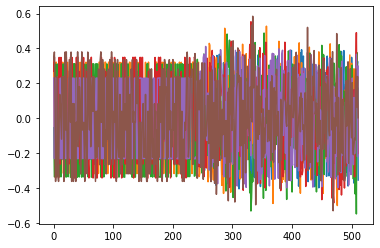

In [85]:
plt.plot(xx)

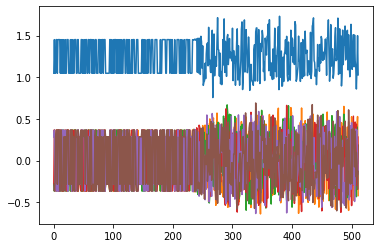

In [86]:
plt.plot(xx2)

In [ ]:
sns.hist(z)

In [8]:
# tau_lst = [0,0.25,0.5,0.75,1,1.5]
# T_lst = [256,512,1024]
# m_lst = [8]

# repli_s =5000

# sigma=1.5
# d_intrinsic = 6 # dimension 
# rho=0.1
# zlst = []
# for a in range(len(tau_lst)):
#     for b in range(len(T_lst)):
#         for c in range(len(m_lst)):
#             tau = tau_lst[a]
#             T =T_lst[b]# sample size
# #             m=m_lst[c]
#             znow = np.load('zval_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_AR_power.npy')
#             znow=np.mean(znow>stats.norm.ppf(0.95))
#             zlst.append((tau, T, znow))

In [9]:
zlst

[(0, 256, 0.0904),
 (0, 512, 0.071),
 (0, 1024, 0.0644),
 (0.25, 256, 0.2644),
 (0.25, 512, 0.3036),
 (0.25, 1024, 0.403),
 (0.5, 256, 0.631),
 (0.5, 512, 0.7714),
 (0.5, 1024, 0.917),
 (0.75, 256, 0.8488),
 (0.75, 512, 0.9438),
 (0.75, 1024, 0.9924),
 (1, 256, 0.9266),
 (1, 512, 0.9766),
 (1, 1024, 0.9992),
 (1.5, 256, 0.965),
 (1.5, 512, 0.9914),
 (1.5, 1024, 0.9998)]

In [35]:
 #znow = np.load('zval_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_AR_power.npy')

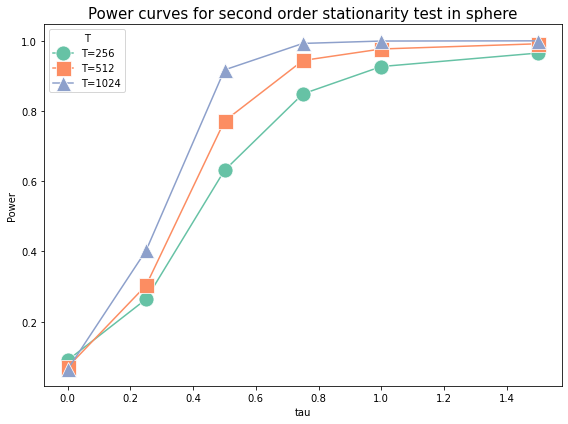

In [10]:
z_array = np.array(zlst, dtype=[('tau', 'f4'), ('T', 'f4'), ('z', 'f4')])

# Creating a DataFrame for seaborn
z_df = pd.DataFrame(z_array)
palette = sns.color_palette("Set2")  # You can choose other palettes
markers = ["o", "s", "^", "D", "x", "*", "P"]  # Different marker styles
plt.figure(figsize=(8, 6))
for i, (T, grp) in enumerate(z_df.groupby('T')):
    sns.lineplot(data=grp, x='tau', y='z', label=f'T={int(T)}',
                 color=palette[i % len(palette)], marker=markers[i % len(markers)],markersize=15)

plt.title('Power curves for second order stationarity test in sphere', fontsize=15)
plt.xlabel('tau')
plt.ylabel('Power')
plt.legend(title='T')
plt.tight_layout()
plt.savefig('Second_order_sphere.png',facecolor='w')

In [14]:
z_array

array([(0.  ,  128., 0.1294), (0.  ,  256., 0.0904),
       (0.  ,  512., 0.071 ), (0.  , 1024., 0.0644),
       (0.25,  128., 0.2784), (0.25,  256., 0.2644),
       (0.25,  512., 0.3036), (0.25, 1024., 0.403 ),
       (0.5 ,  128., 0.5632), (0.5 ,  256., 0.631 ),
       (0.5 ,  512., 0.7714), (0.5 , 1024., 0.917 ),
       (0.75,  128., 0.7724), (0.75,  256., 0.8488),
       (0.75,  512., 0.9438), (0.75, 1024., 0.9924),
       (1.  ,  128., 0.891 ), (1.  ,  256., 0.9266),
       (1.  ,  512., 0.9766), (1.  , 1024., 0.9992),
       (1.5 ,  128., 0.9492), (1.5 ,  256., 0.965 ),
       (1.5 ,  512., 0.9914), (1.5 , 1024., 0.9998)],
      dtype=[('tau', '<f4'), ('T', '<f4'), ('z', '<f4')])

In [8]:
z_mat = np.zeros((5000,4))
T_lst = [64,128,256,512]
for l in range(4):
    T= T_lst[l]
    z_mat[:,l]=np.load('zval_sigma_'+str(1.5)+'rho_'+str(0.15)+'T_'+str(T)+'m_'+str(8)+'_AR_power.npy')


In [9]:
np.mean(z_mat>=stats.norm.ppf(0.95),axis=0)

array([0.789 , 0.882 , 0.9264, 0.9756])